# 1. **CENIPA - Ocorrências Aeronáuticas na Aviação Civil Brasileira**

# 2. Membros (nome e número de matrícula)

Carolina Damacena Peneda – 2018058740

João Aparecido de Brito – 2021027680

Renato Silva Souza – 2024013664

# 3. Descrição dos dados (qual a URL? qual o domínio? como os dados foram processados?)

Os dados brutos foram obtidos no portal de dados abertos do Centro de Investigação e Prevenção de Acidentes Aeronáuticos (CENIPA) (https://dados.gov.br/dados/conjuntos-dados/ocorrencias-aeronauticas-da-aviacao-civil-brasileira), que disponibiliza
arquivos CSV com registros de ocorrências, aeronaves
envolvidas, fatores contribuintes, tipos de ocorrência e recomendações
de segurança. O domínio é segurança da aviação civil brasileira, cobrindo ocorrências aeronáuticas notificadas ao CENIPA a partir de 2007 que ocorreram em solo brasileiro.

Para este projeto, os cinco CSVs (ocorrencia.csv, aeronave.csv,
fator_contribuinte.csv, ocorrencia_tipo.csv, recomendacao.csv)
foram:
1.	Lidos em pandas com encoding latin-1;
2.	Padronizados (coluna codigo_ocorrenciaX → codigo_ocorrencia, remoção
de duplicidades, conversão de NaN para NULL);
3.	Normalizados em 7 tabelas (OCORRENCIA, AERONAVE, TIPO,
FATOR_DETALHE, RECOMENDACAO + 3 tabelas de relacionamento: OCORRENCIA_AERONAVE, OCORRENCIA_FATOR e OCORRENCIA_TIPO) para eliminar
redundância e permitir chaves estrangeiras;
4.	Carregados em um banco SQLite (ocorrencias_novo.db) usando
pandas.to_sql com INSERT OR IGNORE;
5.	Validados com PRAGMA foreign_key_check (retorno vazio indica
integridade referencial).


# 4. Diagrama ER

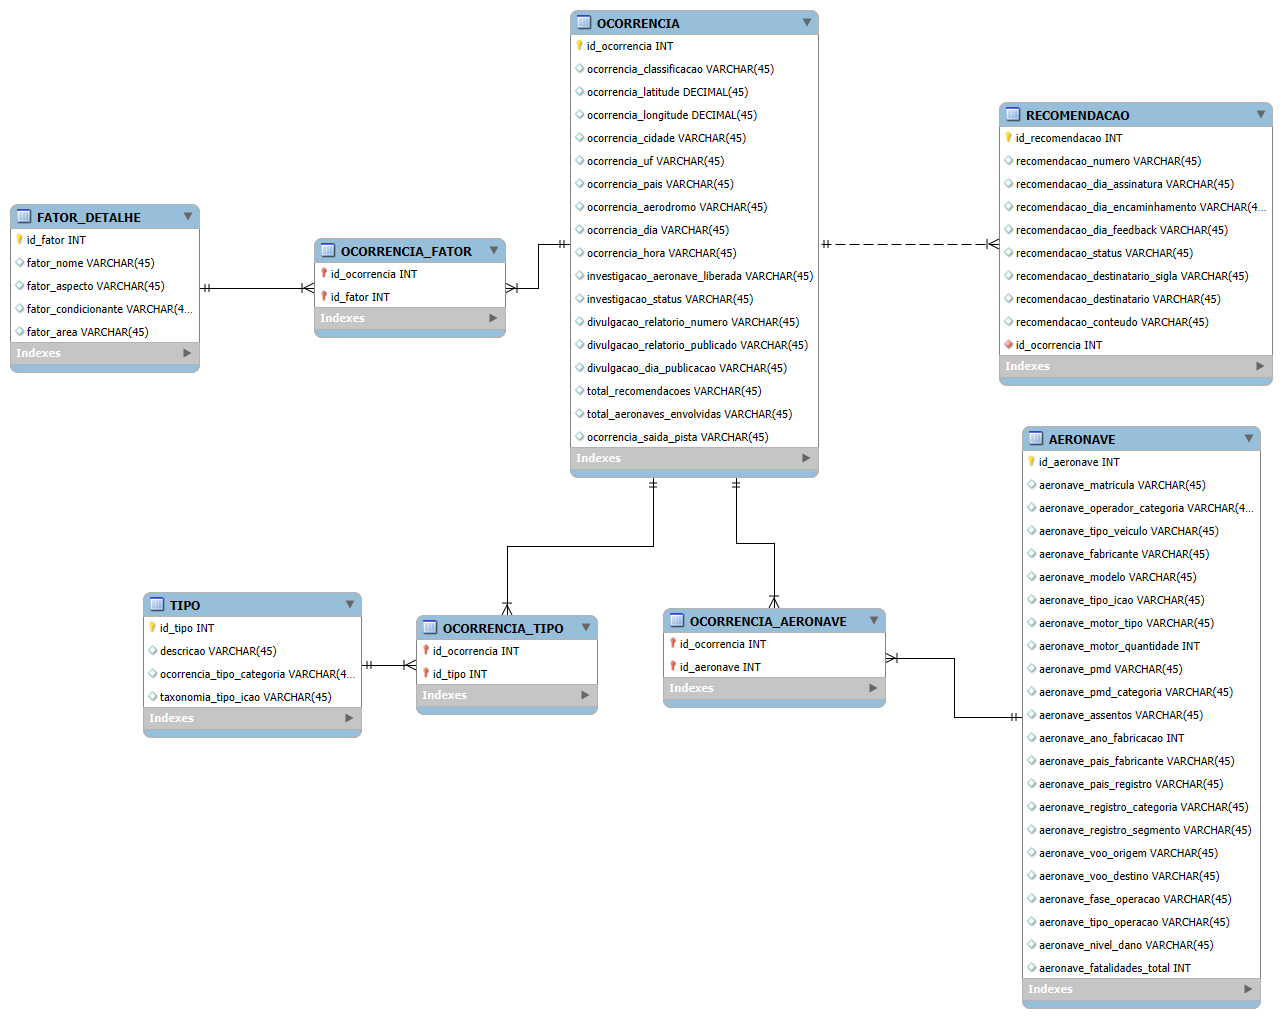

# 5. Diagrama relacional

**OCORRENCIA** (<u>id_ocorrencia</u>, ocorrencia_classificacao, ocorrencia_latitude, ocorrencia_longitude, ocorrencia_cidade, ocorrencia_uf, ocorrencia_pais, ocorrencia_aerodromo, ocorrencia_dia, ocorrencia_hora,investigacao_aeronave_liberada, investigacao_status,divulgacao_relatorio_numero, divulgacao_relatorio_publicado,divulgacao_dia_publicacao, total_recomendacoes, total_aeronaves_envolvidas,ocorrencia_saida_pista)<br><br>

**AERONAVE** (<u>id_aeronave</u>, aeronave_matricula, aeronave_operador_categoria, aeronave_tipo_veiculo, aeronave_fabricante, aeronave_modelo, aeronave_tipo_icao, aeronave_motor_tipo, aeronave_motor_quantidade, aeronave_pmd, aeronave_pmd_categoria, aeronave_assentos, aeronave_ano_fabricacao, aeronave_pais_fabricante, aeronave_pais_registro, aeronave_registro_categoria, aeronave_registro_segmento, aeronave_voo_origem, aeronave_voo_destino, aeronave_fase_operacao, aeronave_tipo_operacao, aeronave_nivel_dano, aeronave_fatalidades_total)<br><br>

**FATOR_DETALHE** (<u>id_fator</u>, fator_nome, fator_aspecto, fator_condicionante, fator_area)<br><br>

**TIPO** (<u>id_tipo</u>, descricao, ocorrencia_tipo_categoria, taxonomia_tipo_icao)<br><br>

**OCORRENCIA_AERONAVE** (id_ocorrencia, id_aeronave)

&emsp; id_ocorrencia referencia OCORRENCIA

&emsp; id_aeronave referencia AERONAVE<br><br>

**OCORRENCIA_FATOR** (id_ocorrencia, id_fator)

&emsp; id_ocorrencia referencia OCORRENCIA

&emsp; id_fator referencia FATOR_DETALHE<br><br>


**OCORRENCIA_TIPO** (id_ocorrencia, id_tipo)

&emsp; id_ocorrencia referencia OCORRENCIA

&emsp; id_tipo referencia TIPO<br><br>


**RECOMENDACAO** (<u>id_recomendacao</u>, id_ocorrencia, recomendacao_numero, recomendacao_dia_assinatura, recomendacao_dia_encaminhamento, recomendacao_dia_feedback, recomendacao_status, recomendacao_destinatario_sigla, recomendacao_destinatario, recomendacao_conteudo)

&emsp; id_ocorrencia referencia OCORRENCIA




In [1]:
# Montagem do google drive

from google.colab import drive
drive.mount('/content/drive')

# Definição de caminhos

BASE = '/content/drive/MyDrive/TP2 - BD/'
DB_FILE = BASE + 'ocorrencias_novo.db'

# Importação de bibliotecas e limpeza de banco antigo (se existir)

from pathlib import Path
import os, re, sqlite3, pandas as pd, numpy as np
if os.path.exists(DB_FILE): os.remove(DB_FILE)

Mounted at /content/drive


In [2]:
# Criação das entidades e relacionamentos

schema = """
PRAGMA foreign_keys = ON;

CREATE TABLE OCORRENCIA (
  id_ocorrencia               INTEGER PRIMARY KEY,
  ocorrencia_classificacao    TEXT,
  ocorrencia_latitude         REAL,
  ocorrencia_longitude        REAL,
  ocorrencia_cidade           TEXT,
  ocorrencia_uf               TEXT,
  ocorrencia_pais             TEXT,
  ocorrencia_aerodromo        TEXT,
  ocorrencia_dia              TEXT,
  ocorrencia_hora             TEXT,
  investigacao_aeronave_liberada TEXT,
  investigacao_status         TEXT,
  divulgacao_relatorio_numero TEXT,
  divulgacao_relatorio_publicado TEXT,
  divulgacao_dia_publicacao   TEXT,
  total_recomendacoes         INTEGER,
  total_aeronaves_envolvidas  INTEGER,
  ocorrencia_saida_pista      TEXT
);

CREATE TABLE AERONAVE (
  id_aeronave                 INTEGER PRIMARY KEY,
  aeronave_matricula          TEXT UNIQUE,
  aeronave_operador_categoria TEXT,
  aeronave_tipo_veiculo       TEXT,
  aeronave_fabricante         TEXT,
  aeronave_modelo             TEXT,
  aeronave_tipo_icao          TEXT,
  aeronave_motor_tipo         TEXT,
  aeronave_motor_quantidade   INTEGER,
  aeronave_pmd                TEXT,
  aeronave_pmd_categoria      TEXT,
  aeronave_assentos           TEXT,
  aeronave_ano_fabricacao     INTEGER,
  aeronave_pais_fabricante    TEXT,
  aeronave_pais_registro      TEXT,
  aeronave_registro_categoria TEXT,
  aeronave_registro_segmento  TEXT,
  aeronave_voo_origem         TEXT,
  aeronave_voo_destino        TEXT,
  aeronave_fase_operacao      TEXT,
  aeronave_tipo_operacao      TEXT,
  aeronave_nivel_dano         TEXT,
  aeronave_fatalidades_total  INTEGER
);

CREATE TABLE TIPO (
  id_tipo INTEGER PRIMARY KEY,
  descricao TEXT,
  ocorrencia_tipo_categoria TEXT,
  taxonomia_tipo_icao TEXT
);

CREATE TABLE FATOR_DETALHE (
  id_fator INTEGER PRIMARY KEY,
  fator_nome          TEXT,
  fator_aspecto       TEXT,
  fator_condicionante TEXT,
  fator_area          TEXT
);

CREATE TABLE OCORRENCIA_AERONAVE (
  id_ocorrencia TEXT,
  id_aeronave   INTEGER,
  PRIMARY KEY (id_ocorrencia,id_aeronave),
  FOREIGN KEY (id_ocorrencia) REFERENCES OCORRENCIA(id_ocorrencia),
  FOREIGN KEY (id_aeronave)   REFERENCES AERONAVE(id_aeronave)
);

CREATE TABLE OCORRENCIA_TIPO (
  id_ocorrencia TEXT,
  id_tipo       INTEGER,
  PRIMARY KEY (id_ocorrencia,id_tipo),
  FOREIGN KEY (id_ocorrencia) REFERENCES OCORRENCIA(id_ocorrencia),
  FOREIGN KEY (id_tipo)       REFERENCES TIPO(id_tipo)
);

CREATE TABLE OCORRENCIA_FATOR (
  id_ocorrencia TEXT,
  id_fator      INTEGER,
  PRIMARY KEY (id_ocorrencia,id_fator),
  FOREIGN KEY (id_ocorrencia) REFERENCES OCORRENCIA(id_ocorrencia),
  FOREIGN KEY (id_fator)      REFERENCES FATOR_DETALHE(id_fator)
);

CREATE TABLE RECOMENDACAO (
  id_recomendacao INTEGER PRIMARY KEY,
  id_ocorrencia   TEXT NOT NULL,
  recomendacao_numero TEXT,
  recomendacao_dia_assinatura TEXT,
  recomendacao_dia_encaminhamento TEXT,
  recomendacao_dia_feedback TEXT,
  recomendacao_status TEXT,
  recomendacao_destinatario_sigla TEXT,
  recomendacao_destinatario TEXT,
  recomendacao_conteudo TEXT,
  FOREIGN KEY (id_ocorrencia) REFERENCES OCORRENCIA(id_ocorrencia)
    ON DELETE CASCADE
);

"""

In [3]:
# Função para padronizar coluna 'codigo_ocorrencia'

def padroniza(df: pd.DataFrame) -> pd.DataFrame:
    df = df.rename(columns=lambda c: c.strip().replace("\ufeff", ""))
    oc_cols = [c for c in df.columns if re.match(r"^codigo_ocorrencia\d*$", c, re.I)]
    if oc_cols and oc_cols[0] != "codigo_ocorrencia":
        df = df.rename(columns={oc_cols[0]: "codigo_ocorrencia"})
    df = df.drop(columns=oc_cols[1:], errors="ignore")
    return df.replace({np.nan: None, "": None})

# Carrega os 5 CSVs e padroniza

ARQ = {
    "aeronave"        : "aeronave.csv",
    "ocorrencia"      : "ocorrencia.csv",
    "recomendacao"    : "recomendacao.csv",
    "fator"           : "fator_contribuinte.csv",
    "ocorrencia_tipo" : "ocorrencia_tipo.csv",
}

raw = {}
for k, arq in ARQ.items():
    df = pd.read_csv(Path(BASE, arq), sep=";", encoding="latin-1", dtype=str)
    df = padroniza(df)
    raw[k] = df
    print(f"{k:<15}:",
          [c for c in df.columns if 'codigo_ocorrencia' in c][:1])

# Criação dos DataFrames normalizados
# ENTIDADES

# OCORRENCIA
df_oc = (raw["ocorrencia"]
         .drop_duplicates("codigo_ocorrencia")
         .rename(columns={"codigo_ocorrencia": "id_ocorrencia"}))

# AERONAVE
df_aer = (raw["aeronave"]
          .drop_duplicates("aeronave_matricula")
          .reset_index(drop=True))
df_aer["id_aeronave"] = df_aer.index + 1
df_aer.drop(columns=["codigo_ocorrencia"], inplace=True, errors="ignore")

# TIPO
df_tipo = (raw["ocorrencia_tipo"]
           .rename(columns={"ocorrencia_tipo": "descricao"})
           .drop_duplicates("descricao")
           .reset_index(drop=True))
df_tipo["id_tipo"] = df_tipo.index + 1

# FATOR_DETALHE
df_fat_det = (raw["fator"]
              .drop_duplicates(["fator_nome","fator_aspecto",
                                "fator_condicionante","fator_area"])
              .reset_index(drop=True))
df_fat_det["id_fator"] = df_fat_det.index + 1

# RELACIONAMENTOS

# OCORRENCIA_AERONAVE
df_oc_aer = (raw["aeronave"]
             .merge(df_aer[["id_aeronave","aeronave_matricula"]],
                    on="aeronave_matricula", how="left")
             [["codigo_ocorrencia","id_aeronave"]]
             .rename(columns={"codigo_ocorrencia":"id_ocorrencia"})
             .dropna().drop_duplicates())

# OCORRENCIA_TIPO
df_oc_tipo = (raw["ocorrencia_tipo"]
              .rename(columns={"ocorrencia_tipo":"descricao"})
              .merge(df_tipo[["id_tipo","descricao"]],
                     on="descricao", how="left")
              [["codigo_ocorrencia","id_tipo"]]
              .rename(columns={"codigo_ocorrencia":"id_ocorrencia"})
              .dropna().drop_duplicates())

df_fat_det = df_fat_det.drop(columns='codigo_ocorrencia', errors='ignore')

# OCORRENCIA_FATOR
df_oc_fat = (raw['fator']
             .merge(df_fat_det,
                    on=['fator_nome','fator_aspecto',
                        'fator_condicionante','fator_area'],
                    how='left')
             [['codigo_ocorrencia','id_fator']]
             .rename(columns={'codigo_ocorrencia':'id_ocorrencia'})
             .dropna()
             .drop_duplicates())

# RECOMENDACAO (relacionamento 1:N)
df_rec = raw["recomendacao"].copy()
df_rec["id_recomendacao"] = range(1, len(df_rec) + 1)
df_rec.rename(columns={"codigo_ocorrencia": "id_ocorrencia"}, inplace=True)

# Grava no SQLite com INSERT OR IGNORE

def insert_ignore(table, conn, keys, data_iter):
    sql = f"INSERT OR IGNORE INTO {table.name} " \
          f"({', '.join(keys)}) VALUES ({', '.join(['?']*len(keys))})"
    conn.executemany(sql, list(data_iter))

with sqlite3.connect(DB_FILE) as conn:

    df_oc.to_sql('OCORRENCIA', conn,
                if_exists='append', index=False, method=insert_ignore)

    df_aer.to_sql('AERONAVE', conn,
                  if_exists='append', index=False, method=insert_ignore)

    df_tipo[['id_tipo',
            'descricao',
            'ocorrencia_tipo_categoria',
            'taxonomia_tipo_icao']].to_sql(
                'TIPO', conn,
                if_exists='append', index=False, method=insert_ignore)


    df_fat_det.to_sql('FATOR_DETALHE', conn,
                      if_exists='append', index=False, method=insert_ignore)

    df_oc_aer.to_sql('OCORRENCIA_AERONAVE', conn,
                    if_exists='append', index=False, method=insert_ignore)

    df_oc_tipo.to_sql('OCORRENCIA_TIPO', conn,
                      if_exists='append', index=False, method=insert_ignore)

    df_oc_fat.to_sql('OCORRENCIA_FATOR', conn,
                    if_exists='append', index=False, method=insert_ignore)

    df_rec.to_sql('RECOMENDACAO', conn,
                  if_exists='append', index=False, method=insert_ignore)

    print("FK check:", conn.execute("PRAGMA foreign_key_check").fetchall())

aeronave       : ['codigo_ocorrencia']
ocorrencia     : ['codigo_ocorrencia']
recomendacao   : ['codigo_ocorrencia']
fator          : ['codigo_ocorrencia']
ocorrencia_tipo: ['codigo_ocorrencia']
FK check: []


In [4]:
# DataFrame com IDs que realmente existem
ids_ok = set(df_oc['id_ocorrencia'])

# Separa as recomendações válidas e inválidas
mask_orfas = ~raw['recomendacao']['codigo_ocorrencia'].isin(ids_ok)

df_rec_err = raw['recomendacao'][mask_orfas]        # órfãs
df_rec_ok  = raw['recomendacao'][~mask_orfas]       # válidas

print("Recomendações órfãs :", len(df_rec_err))
print("Recomendações válidas:", len(df_rec_ok))

Recomendações órfãs : 696
Recomendações válidas: 2692


In [5]:
# Exibe pré-visualização das reconmendações órfãs

display(df_rec_err[['codigo_ocorrencia','recomendacao_numero']].head())

,codigo_ocorrencia,recomendacao_numero
2692,que o objetivo da recomendação de segurança fo...,A-507/CENIPA/2015  001
2693,"a Nota Técnica nº 77/2016/GTFH/GCEP/SPO, acolh...",None
2694,"Operacionais, considerou-a não aplicável, sust...",None
2695,que a metodologia da análise profissiográfica ...,None
2696,ausência de morbidade e o entendimento de sua,None


In [6]:
# Renomeia a coluna de código e descarta linhas sem ocorrência correspondente
df_rec = (df_rec_ok
          .rename(columns={'codigo_ocorrencia':'id_ocorrencia'})
          .dropna(subset=['id_ocorrencia']))

# Grava no SQLite
df_rec.to_sql('RECOMENDACAO', conn,
              if_exists='append', index=False, method=insert_ignore)

In [7]:
# Mostra todas as violações de chave estrangeira no banco

print("FK check:", conn.execute("PRAGMA foreign_key_check").fetchall())

FK check: []


In [8]:
# Captura as linhas das recomendações órfãs

with sqlite3.connect(DB_FILE) as conn:
    orfas = conn.execute("""
        SELECT id_recomendacao, id_ocorrencia
        FROM   RECOMENDACAO
        WHERE  id_ocorrencia NOT IN (SELECT id_ocorrencia FROM OCORRENCIA);
    """).fetchall()

print(orfas)

[(2693, 'que o objetivo da recomendação de segurança foi cumprido, uma vez que seu conteúdo é abrangido pelas inspeções da ANAC."\n"45820"'), (2694, 'a Nota Técnica nº 77/2016/GTFH/GCEP/SPO, acolhida sem ressalvas pela Superintendência de Padrões'), (2695, 'Operacionais, considerou-a não aplicável, sustentando'), (2696, 'que a metodologia da análise profissiográfica no âmbito das perícias médicas (em conformidade com o RBAC 67) não contribuiria para o principal objetivo de tais avaliações, que é o de identificar a presença ou'), (2697, 'ausência de morbidade e o entendimento de sua'), (2698, 'gravidade. A análise profissiográfica, ainda de acordo'), (2699, 'com a Nota Técnica é própria para avaliações psicológicas de seleção de pessoal, por julgar as'), (2700, 'potencialidades e não as limitações impeditivas, não'), (2701, 'tendo por finalidade auxiliar a pesquisa diagnóstica'), (2702, 'no campo da saúde mental, ao passo que a perícia'), (2703, 'médica é um processo distinto, o qual de

In [9]:
# Exclusão dessas linhas para eliminar a violação

with sqlite3.connect(DB_FILE) as conn:
    conn.executemany(
        "DELETE FROM RECOMENDACAO WHERE id_recomendacao = ?",
        [(r[0],) for r in orfas]
    )
    print("FK check:", conn.execute("PRAGMA foreign_key_check").fetchall()) # novo resultado

FK check: []


In [10]:
# CHECK 1

with sqlite3.connect(DB_FILE) as conn:
    n_err = conn.execute("""
        SELECT COUNT(*)
        FROM OCORRENCIA_AERONAVE oa
        LEFT JOIN OCORRENCIA o  USING(id_ocorrencia)
        LEFT JOIN AERONAVE   a  USING(id_aeronave)
        WHERE o.id_ocorrencia IS NULL
           OR a.id_aeronave   IS NULL;
    """).fetchone()[0]
    print("Linhas na ponte OA sem pai:", n_err)   # 0 = tudo ok

Linhas na ponte OA sem pai: 0


In [11]:
# CHECK 2

with sqlite3.connect(DB_FILE) as conn:
    dup = conn.execute("""
        SELECT id_ocorrencia, COUNT(*)
        FROM OCORRENCIA
        GROUP BY id_ocorrencia
        HAVING COUNT(*) > 1
        LIMIT 10;
    """).fetchall()
    print("Duplicatas em OCORRENCIA:", dup)   # deve ser []


Duplicatas em OCORRENCIA: []


In [12]:
# CHECK 3

with sqlite3.connect(DB_FILE) as conn:
    df_ot_orfas = pd.read_sql_query("""
        SELECT ot.rowid AS rowid_ot,
               ot.id_ocorrencia,
               ot.id_tipo
        FROM   OCORRENCIA_TIPO ot
        LEFT JOIN OCORRENCIA o USING (id_ocorrencia)
        WHERE  o.id_ocorrencia IS NULL;
    """, conn)

print("Linhas órfãs em OCORRENCIA_TIPO:", len(df_ot_orfas))
display(df_ot_orfas.head())

Linhas órfãs em OCORRENCIA_TIPO: 4


,rowid_ot,id_ocorrencia,id_tipo
0,2931,83607,1
1,4954,81202,7
2,5129,81013,7
3,6022,80091,8


In [13]:
# RESOLUÇÃO CHECK 3

with sqlite3.connect(DB_FILE) as conn:
    conn.execute("""
        DELETE FROM OCORRENCIA_TIPO
        WHERE id_ocorrencia NOT IN (SELECT id_ocorrencia FROM OCORRENCIA);
    """)

    print("FK check:", conn.execute("PRAGMA foreign_key_check").fetchall())

FK check: []


In [14]:
# CHECK 4

with sqlite3.connect(DB_FILE) as conn:
    print("PRAGMA integrity_check :", conn.execute("PRAGMA integrity_check").fetchone()[0])
    print("PRAGMA foreign_key_check :", conn.execute("PRAGMA foreign_key_check").fetchall())

PRAGMA integrity_check : ok
PRAGMA foreign_key_check : []


In [15]:
# CONFERENCIA

with sqlite3.connect(DB_FILE) as conn:
    tabelas = [r[0] for r in conn.execute(
        "SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;")]

    for tbl in tabelas:
        colunas = [r[1] for r in conn.execute(f"PRAGMA table_info('{tbl}');")]
        print(f"{tbl:<20}: {colunas}")

AERONAVE            : ['aeronave_matricula', 'aeronave_operador_categoria', 'aeronave_tipo_veiculo', 'aeronave_fabricante', 'aeronave_modelo', 'aeronave_tipo_icao', 'aeronave_motor_tipo', 'aeronave_motor_quantidade', 'aeronave_pmd', 'aeronave_pmd_categoria', 'aeronave_assentos', 'aeronave_ano_fabricacao', 'aeronave_pais_fabricante', 'aeronave_pais_registro', 'aeronave_registro_categoria', 'aeronave_registro_segmento', 'aeronave_voo_origem', 'aeronave_voo_destino', 'aeronave_fase_operacao', 'aeronave_tipo_operacao', 'aeronave_nivel_dano', 'aeronave_fatalidades_total', 'id_aeronave']
FATOR_DETALHE       : ['fator_nome', 'fator_aspecto', 'fator_condicionante', 'fator_area', 'id_fator']
OCORRENCIA          : ['id_ocorrencia', 'ocorrencia_classificacao', 'ocorrencia_latitude', 'ocorrencia_longitude', 'ocorrencia_cidade', 'ocorrencia_uf', 'ocorrencia_pais', 'ocorrencia_aerodromo', 'ocorrencia_dia', 'ocorrencia_hora', 'investigacao_aeronave_liberada', 'investigacao_status', 'divulgacao_relato

# 6. Consultas

## 6.1 Duas consultas envolvendo seleção e projeção

### 6.1.1 Consulta 1

In [16]:
# Incidentes graves por UF após 2015

pd.read_sql_query("""
SELECT ocorrencia_uf,
       ocorrencia_dia,
       ocorrencia_cidade
FROM   OCORRENCIA
WHERE  ocorrencia_classificacao LIKE '%GRAVE%'
  AND  SUBSTR(ocorrencia_dia,7,4) >= '2015'
ORDER  BY SUBSTR(ocorrencia_dia,7,4)||SUBSTR(ocorrencia_dia,4,2)||SUBSTR(ocorrencia_dia,1,2) DESC LIMIT  20;
""", conn)

,ocorrencia_uf,ocorrencia_dia,ocorrencia_cidade
0,GO,29/04/2025,GOIÂNIA
1,MT,22/04/2025,NOSSA SENHORA DO LIVRAMENTO
2,MS,20/04/2025,PORTO MURTINHO
3,RS,14/04/2025,ARROIO GRANDE
4,RR,12/04/2025,CANTÁ
5,MG,11/04/2025,UBERABA
6,GO,10/04/2025,GOIÂNIA
7,BA,10/04/2025,EUNÁPOLIS
8,SC,05/04/2025,GARUVA
9,GO,03/04/2025,PIRENÓPOLIS


### 6.1.2 Consulta 2

In [17]:
# Aeronaves fabricadas antes de 1980

pd.read_sql_query("""
SELECT aeronave_matricula,
       aeronave_fabricante,
       aeronave_modelo,
       aeronave_ano_fabricacao
FROM   AERONAVE
WHERE  CAST(aeronave_ano_fabricacao AS INTEGER) BETWEEN 1900 AND 1979
ORDER  BY aeronave_ano_fabricacao LIMIT 5;
""", conn)

,aeronave_matricula,aeronave_fabricante,aeronave_modelo,aeronave_ano_fabricacao
0,PPZXY,WACO AIRCRAFT,QCF-2,1931
1,PRSTW,BEECH AIRCRAFT,C17L,1936
2,PTKYP,CIA AERONAUTICA PAULISTA,CAP-4,1940
3,PTLDO,NORTH AMERICAN AVIATION,AT-6D,1942
4,PRMSY,MCDONNELL DOUGLAS,DC3-TP67,1944


## 6.2 Três consultas envolvendo junção de duas relações

### 6.2.1 Consulta 3

In [18]:
# Tipos de ocorrências mais frequentes

pd.read_sql_query("""
SELECT t.descricao AS tipo,
       COUNT(*) AS ocorrencias
FROM   OCORRENCIA_TIPO ot
JOIN   TIPO t USING (id_tipo)
GROUP  BY t.descricao
ORDER  BY ocorrencias DESC
LIMIT  10;
""", conn)

,tipo,ocorrencias
0,FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPON...,2628
1,COLISÃO COM AVE,2227
2,FALHA DO MOTOR EM VOO,1135
3,ESTOURO DE PNEU,902
4,PERDA DE CONTROLE NO SOLO,726
5,EXCURSÃO DE PISTA,642
6,PERDA DE CONTROLE EM VOO,585
7,COM TREM DE POUSO,554
8,OUTROS,481
9,FALHA OU MAU FUNCIONAMENTO DO MOTOR,402


### 6.2.2 Consulta 4

In [19]:
# Fatores contribuintes em incidentes graves

pd.read_sql_query("""
SELECT  fd.fator_nome,
        COUNT(*) AS vezes
FROM    OCORRENCIA_FATOR  ofa
JOIN    FATOR_DETALHE     fd  USING (id_fator)
JOIN    OCORRENCIA        o   USING (id_ocorrencia)
WHERE   o.ocorrencia_classificacao LIKE '%GRAVE%'
GROUP BY fd.fator_nome
ORDER BY vezes DESC
LIMIT   10;
""", conn)

,fator_nome,vezes
0,JULGAMENTO DE PILOTAGEM,158
1,APLICAÇÃO DE COMANDOS,137
2,MANUTENÇÃO DA AERONAVE,129
3,SUPERVISÃO GERENCIAL,114
4,PLANEJAMENTO DE VOO,65
5,COORDENAÇÃO DE CABINE,59
6,ATITUDE,56
7,PROCESSO DECISÓRIO,54
8,POUCA EXPERIÊNCIA DO PILOTO,51
9,PERCEPÇÃO,51


### 6.2.3 Consulta 5

In [20]:
# Fabricantes de aeronaves que aparecem em 2 ou mais ocorrências

pd.read_sql_query("""
SELECT a.aeronave_fabricante,
       COUNT(DISTINCT oa.id_ocorrencia) AS qty_ocorrencias
FROM   OCORRENCIA_AERONAVE oa
JOIN   AERONAVE a USING (id_aeronave)
GROUP  BY a.aeronave_fabricante
HAVING qty_ocorrencias >= 2
ORDER  BY qty_ocorrencias DESC LIMIT 5;
""", conn)

,aeronave_fabricante,qty_ocorrencias
0,CESSNA AIRCRAFT,1524
1,EMBRAER,1499
2,BOEING,1391
3,AIRBUS,1305
4,NEIVA,687


## 6.3 Três consultas envolvendo junção de três ou mais relações

### 6.3.1 Consulta 6

In [21]:
# Correlação entre modelo da aeronave e tipo de ocorrência, e quantas vezes essa correlação se repete

pd.read_sql_query("""
SELECT a.aeronave_modelo AS modelo,
       t.descricao AS tipo,
       COUNT(*) AS qtd
FROM   OCORRENCIA o
JOIN   OCORRENCIA_AERONAVE oa USING (id_ocorrencia)
JOIN   AERONAVE a USING (id_aeronave)
JOIN   OCORRENCIA_TIPO ot USING (id_ocorrencia)
JOIN   TIPO t USING (id_tipo)
GROUP  BY modelo, tipo
ORDER  BY qtd DESC
LIMIT  10;
""", conn)

,modelo,tipo,qtd
0,A320-214,COLISÃO COM AVE,216
1,***,COLISÃO COM AVE,212
2,737-8EH,COLISÃO COM AVE,210
3,A320-251N,COLISÃO COM AVE,190
4,ERJ 190-200 IGW,FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPON...,176
5,ATR-72-212A,FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPON...,174
6,AB-115,PERDA DE CONTROLE NO SOLO,162
7,737-8 MAX,COLISÃO COM AVE,152
8,ERJ 190-200 IGW,COLISÃO COM AVE,129
9,A320-251N,FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPON...,104


### 6.3.2 Consulta 7

In [22]:
# Correlação entre tipo de operação e gravidade da ocorrência, e quantas vezes essa correlação se repete

pd.read_sql_query("""
SELECT a.aeronave_tipo_operacao AS tipo_operacao,
       o.ocorrencia_classificacao AS gravidade,
       COUNT(*) AS total
FROM   OCORRENCIA o
JOIN   OCORRENCIA_AERONAVE oa USING (id_ocorrencia)
JOIN   AERONAVE a USING (id_aeronave)
GROUP  BY tipo_operacao, gravidade
ORDER  BY total DESC LIMIT 10;
""", conn)

,tipo_operacao,gravidade,total
0,REGULAR,INCIDENTE,4496
1,PRIVADA,INCIDENTE,1589
2,PRIVADA,ACIDENTE,1217
3,***,INCIDENTE,1101
4,TÁXI AÉREO,INCIDENTE,943
5,AGRÍCOLA,ACIDENTE,645
6,INSTRUÇÃO,INCIDENTE,615
7,PRIVADA,INCIDENTE GRAVE,497
8,INSTRUÇÃO,ACIDENTE,327
9,EXPERIMENTAL,ACIDENTE,221


### 6.3.3 Consulta 8

In [23]:
# Correlação entre idade da aeronave e gravidade da ocorrência, e quantas vezes essa correlação se repete

pd.read_sql_query("""
SELECT
    CAST(SUBSTR(o.ocorrencia_dia,7,4) AS INTEGER)
    - a.aeronave_ano_fabricacao AS idade,
    o.ocorrencia_classificacao AS gravidade,
    COUNT(*) AS total
FROM   OCORRENCIA            o
JOIN   OCORRENCIA_AERONAVE   oa USING (id_ocorrencia)
JOIN   AERONAVE              a  USING (id_aeronave)
WHERE  a.aeronave_ano_fabricacao BETWEEN 1900 AND 2025
  AND  SUBSTR(o.ocorrencia_dia,7,4) BETWEEN '1900' AND '2025'
  AND gravidade LIKE "%ACIDENTE%"
GROUP  BY idade, gravidade
HAVING idade BETWEEN 0 AND 80
ORDER  BY total DESC LIMIT  5;
""", conn)

,idade,gravidade,total
0,11,ACIDENTE,72
1,17,ACIDENTE,68
2,8,ACIDENTE,67
3,10,ACIDENTE,64
4,37,ACIDENTE,63


## 6.4 Duas consultas envolvendo agregação sobre junção de duas ou mais relações

### 6.4.1 Consulta 9

In [24]:
# Média de recomendações por gravidade de ocorrência

pd.read_sql_query("""
SELECT o.ocorrencia_classificacao AS gravidade,
       ROUND(AVG(r.qtd_recs), 2) AS media_recs,
       COUNT(*) AS ocorrencias_analisadas
FROM (
        SELECT id_ocorrencia,
               COUNT(*) AS qtd_recs
        FROM   RECOMENDACAO
        GROUP  BY id_ocorrencia
     ) AS r
JOIN  OCORRENCIA o USING (id_ocorrencia)
GROUP BY gravidade
ORDER BY media_recs DESC;
""", conn)

,gravidade,media_recs,ocorrencias_analisadas
0,ACIDENTE,6.52,670
1,INCIDENTE,5.86,28
2,INCIDENTE GRAVE,5.56,153


### 6.4.2 Consulta 10

In [25]:
# Quais fatores contribuintes geram, em média, o maior número de recomendações por ocorrência?

pd.read_sql_query("""

WITH oc_por_fator AS (
  SELECT id_fator,
         COUNT(DISTINCT id_ocorrencia) AS ocorrencias
  FROM   OCORRENCIA_FATOR
  GROUP  BY id_fator
), rec_por_fator AS (
    SELECT ofa.id_fator,
          COUNT(*) AS total_recs
    FROM   OCORRENCIA_FATOR ofa
    JOIN   RECOMENDACAO   r USING (id_ocorrencia)
    GROUP  BY ofa.id_fator
  )

SELECT fd.fator_nome,
       oc.ocorrencias,
       rec.total_recs,
       ROUND(1.0 * rec.total_recs / oc.ocorrencias, 2) AS media_recs_por_ocor
FROM   oc_por_fator oc
JOIN   rec_por_fator rec USING (id_fator)
JOIN   FATOR_DETALHE  fd  USING (id_fator)
WHERE  oc.ocorrencias >= 5          -- filtra fatores pouco frequentes
ORDER  BY media_recs_por_ocor DESC  -- maior média primeiro
LIMIT  10;
""", conn)

,fator_nome,ocorrencias,total_recs,media_recs_por_ocor
0,ANSIEDADE,7,220,31.43
1,CLIMA ORGANIZACIONAL,11,220,20.00
2,INDÍCIOS DE ESTRESSE,24,342,14.25
3,PROJETO,45,504,11.20
4,LIDERANÇA,7,62,8.86
5,INFLUÊNCIA DO MEIO AMBIENTE,47,396,8.43
6,SUPERVISÃO (ATS),6,50,8.33
7,DINÂMICA DE EQUIPE,46,358,7.78
8,COORDENAÇÃO DE TRÁFEGO (ATS),8,62,7.75
9,ILUSÕES VISUAIS,22,168,7.64


### Streamlit

In [26]:
%%writefile app.py

from pathlib import Path
import sqlite3

import altair as alt
import pandas as pd
import pydeck as pdk
import streamlit as st

DB_FILE = Path("/content/drive/MyDrive/TP2 - BD/ocorrencias_novo.db")
PINK = "#f6b5d1"

@st.cache_data
def run_query(sql: str, params: tuple | None = None) -> pd.DataFrame:
    with sqlite3.connect(DB_FILE) as conn:
        return pd.read_sql_query(sql, conn, params=params)

q_list = [
    "Incidentes graves recentes por UF",
    "Tipos de ocorrência mais frequentes",
    "Fatores contribuintes em incidentes graves",
    "Fabricantes de aeronaves que aparecem em 2 ou mais ocorrências",
    "Correlação entre modelo da aeronave e tipo de ocorrência",
    "Correlação entre tipo de operação e gravidade da ocorrência (top-10)",
    "Correlação entre idade da aeronave e acidentes",
    "Média recomendações × total ocorrências por ano",
    "Fatores com maior média de recomendações por ocorrência"
]

query_name = st.sidebar.selectbox("Consultas", q_list)

st.set_page_config(page_title="Dashboard Ocorrências", layout="wide")
st.title("CENIPA - Ocorrências Aeronáuticas na Aviação Civil Brasileira")
st.subheader(query_name)

# Q1 – Incidentes graves recentes por UF

if query_name.startswith("Incidentes graves recentes por UF"):
    sql = """
        SELECT ocorrencia_uf, ocorrencia_cidade,
               ocorrencia_dia, ocorrencia_latitude AS lat,
               ocorrencia_longitude AS lon
        FROM   OCORRENCIA
        WHERE  ocorrencia_classificacao LIKE '%GRAVE%'
          AND  SUBSTR(ocorrencia_dia,7,4) >= '2015'
          AND  lat IS NOT NULL AND lon IS NOT NULL
        ORDER  BY SUBSTR(ocorrencia_dia,7,4)||SUBSTR(ocorrencia_dia,4,2)||SUBSTR(ocorrencia_dia,1,2) DESC
        LIMIT  10;
    """
    df = run_query(sql)

    st.caption("⚠️ **Goiânia (GO)** concentrou 3 dos 20 incidentes "
               "graves mais recentes – auditorias recomendadas.")

    # converte strings “-23,45” → float, descarta vazios
    df[["lat","lon"]] = (df[["lat","lon"]]
                         .replace(",", ".", regex=True)
                         .astype(float, errors="ignore"))
    df = df.dropna(subset=["lat","lon"])

    st.dataframe(df, height=250)

    if df.empty:
        st.info("Sem coordenadas válidas para essas ocorrências.")
    else:
        st.pydeck_chart(
            pdk.Deck(
                initial_view_state=pdk.ViewState(
                    latitude=df.lat.mean(),
                    longitude=df.lon.mean(),
                    zoom=4
                ),
                layers=[
                    pdk.Layer(
                        "ScatterplotLayer",  # ← sem barra
                        data=df,
                        get_position="[lon, lat]",
                        get_radius=30000,
                        get_color=[245, 102, 135, 120],
                    )
                ],
            )
        )

# Q3 – Tipos de ocorrências mais frequentes

elif query_name.startswith("Tipos de ocorrência mais frequentes"):
    sql = """
      SELECT t.descricao AS tipo,
            COUNT(*) AS ocorrencias
      FROM   OCORRENCIA_TIPO ot
      JOIN   TIPO t USING (id_tipo)
      GROUP  BY t.descricao
      ORDER  BY ocorrencias DESC
      LIMIT  10;
    """
    df = run_query(sql)

    st.caption("⚠️ **Falha ou mau funcionamento de sistema/componente** é o tipo de ocorrência mais comum "
               " - ações preventivas são urgentes.")

    st.altair_chart(alt.Chart(df).mark_bar(color=PINK).encode(x="tipo:N", y="ocorrencias:Q", tooltip=["tipo","ocorrencias"]).properties(height=320), use_container_width=True)

# Q4 – Fatores contribuintes em incidentes graves

elif query_name.startswith("Fatores contribuintes em incidentes graves"):
    sql = """
      SELECT  fd.fator_nome,
              COUNT(*) AS vezes
      FROM    OCORRENCIA_FATOR  ofa
      JOIN    FATOR_DETALHE     fd  USING (id_fator)
      JOIN    OCORRENCIA        o   USING (id_ocorrencia)
      WHERE   o.ocorrencia_classificacao LIKE '%GRAVE%'
      GROUP BY fd.fator_nome
      ORDER BY vezes DESC
      LIMIT   10;
    """
    df = run_query(sql)

    st.caption("⚠️ Julgamento de pilotagem e manutenção da aeronave lideram entre os fatores mais presentes em incidentes graves.")

    st.altair_chart(alt.Chart(df).mark_bar(color=PINK).encode(x="fator_nome:N", y="vezes:Q", tooltip=["fator_nome","vezes"]).properties(height=320), use_container_width=True)

# Q5 – Fabricantes de aeronaves que aparecem em 2 ou mais ocorrências

elif query_name.startswith("Fabricantes de aeronaves que aparecem em 2 ou mais ocorrências"):
    sql = """
      SELECT a.aeronave_fabricante      AS fabricante,
             COUNT(DISTINCT oa.id_ocorrencia) AS qtd
      FROM   OCORRENCIA_AERONAVE oa
      JOIN   AERONAVE a USING (id_aeronave)
      GROUP  BY fabricante
      HAVING qtd >= 2
      ORDER  BY qtd DESC
      LIMIT  5;
    """
    df = run_query(sql)

    st.caption("⚠️ Cessna, Embraer e Boeing concentram a maioria das ocorrências.")

    import altair as alt

    color=alt.Color("fabricante:N",
                    scale=alt.Scale(range=["#f6b5d1","#f48fb1",
                                          "#f06292","#ec407a",
                                          "#e91e63"]),
                    legend=alt.Legend(title="Fabricante"))


    pie = (
        alt.Chart(df)
           .mark_arc(innerRadius=50, outerRadius=140)   # donut
           .encode(
               theta="qtd:Q",
               color=alt.Color("fabricante:N",
                               legend=alt.Legend(title="Fabricante")),
               tooltip=["fabricante:N", "qtd:Q"]
           )
           .properties(height=350)
    )

    st.altair_chart(pie, use_container_width=True)

# Q6 – Correlação entre modelo da aeronave e tipo de ocorrência, e quantas vezes essa correlação se repete

elif query_name.startswith("Correlação entre modelo da aeronave e tipo de ocorrência"):
    sql = """
        SELECT a.aeronave_modelo  AS modelo,
               t.descricao        AS tipo,
               COUNT(*)           AS total
        FROM   OCORRENCIA o
        JOIN   OCORRENCIA_AERONAVE oa USING(id_ocorrencia)
        JOIN   AERONAVE a            USING(id_aeronave)
        JOIN   OCORRENCIA_TIPO  ot   USING(id_ocorrencia)
        JOIN   TIPO t                USING(id_tipo)
        GROUP  BY modelo, tipo
    """
    df = run_query(sql)

    st.caption("⚠️ A320 e Boeing 737 concentram colisões com aves; ERJ e ATR se destacam por falhas sistêmicas – atenção às tendências por modelo.")

    top20 = df.groupby("modelo")['total'].sum().nlargest(20).index
    df = df[df['modelo'].isin(top20)]

    modelo_sel = st.selectbox("Escolha o modelo", sorted(top20))
    df_mod = df[df['modelo'] == modelo_sel]
    df_mod = df_mod.nlargest(6, 'total')  # top‑6 tipos

    pie = (
        alt.Chart(df_mod)
           .mark_arc(innerRadius=50, outerRadius=120, stroke='white')
           .encode(theta="total:Q", color=alt.Color('tipo:N', scale=alt.Scale(scheme='tableau10')), tooltip=['tipo','total'])
    )
    st.altair_chart(pie, use_container_width=True)

# Q7 – Correlação entre tipo de operação e gravidade da ocorrência, e quantas vezes essa correlação se repete

elif query_name.startswith("Correlação entre tipo de operação e gravidade da ocorrência"):
    sql = """
      SELECT a.aeronave_tipo_operacao  AS tipo_operacao,
             o.ocorrencia_classificacao AS gravidade,
             COUNT(*)                  AS total
      FROM   OCORRENCIA o
      JOIN   OCORRENCIA_AERONAVE oa USING (id_ocorrencia)
      JOIN   AERONAVE a            USING (id_aeronave)
      WHERE  a.aeronave_tipo_operacao <> '***'
      GROUP  BY tipo_operacao, gravidade
      ORDER  BY total DESC
      LIMIT  10;
    """
    df = run_query(sql)

    st.caption("⚠️ Operações privadas concentram a maior proporção de incidentes graves.")

    import altair as alt

    bar = (
        alt.Chart(df)
           .mark_bar(size=25)
           .encode(
               x = alt.X("tipo_operacao:N",
                         sort="-y",
                         title="Tipo de operação"),
               y = alt.Y("total:Q",
                         title="Ocorrências"),
               color = alt.Color("gravidade:N",
                                 legend=alt.Legend(title="Gravidade")),
               tooltip = ["tipo_operacao", "gravidade", "total"]
           )
           .properties(height=320)
    )

    st.altair_chart(bar, use_container_width=True)

# Q8 – Correlação entre idade da aeronave e acidentes, e quantas vezes essa correlação se repete

elif query_name.startswith("Correlação entre idade da aeronave e acidentes"):
    sql = """
      SELECT
          CAST(SUBSTR(o.ocorrencia_dia,7,4) AS INTEGER)
          - a.aeronave_ano_fabricacao AS idade,
          o.ocorrencia_classificacao AS gravidade,
          COUNT(*) AS total
      FROM   OCORRENCIA            o
      JOIN   OCORRENCIA_AERONAVE   oa USING (id_ocorrencia)
      JOIN   AERONAVE              a  USING (id_aeronave)
      WHERE  a.aeronave_ano_fabricacao BETWEEN 1900 AND 2025
        AND  SUBSTR(o.ocorrencia_dia,7,4) BETWEEN '1900' AND '2025'
        AND gravidade LIKE "%ACIDENTE%"
      GROUP  BY idade, gravidade
      HAVING idade BETWEEN 0 AND 80
      ORDER  BY total DESC LIMIT  5;
    """
    df = run_query(sql)

    st.caption("⚠️ Aeronaves com mais de 10 anos mantêm altos índices de ocorrência.")

    chart_type = st.radio("Formato:", ["Barra", "Linha"], horizontal=True)

    if chart_type == "Barra":
        chart = alt.Chart(df).mark_bar(color=PINK).encode(
                x="idade:O", y="total:Q", tooltip=["idade","total"])
    else:
        chart = alt.Chart(df).mark_line(point=True, color=PINK).encode(
                x="idade:O", y="total:Q", tooltip=["idade","total"])

    st.altair_chart(chart.properties(height=320), use_container_width=True)

# Q9 – Média de recomendações por gravidade de ocorrência

elif query_name.startswith("Média recomendações × total ocorrências por ano"):
    df_med = run_query("""
        SELECT SUBSTR(o.ocorrencia_dia,7,4) AS ano,
               ROUND(AVG(r.qtd),2)          AS media_recs
        FROM (SELECT id_ocorrencia, COUNT(*) AS qtd FROM RECOMENDACAO GROUP BY id_ocorrencia) r
        JOIN OCORRENCIA o USING(id_ocorrencia)
        WHERE SUBSTR(o.ocorrencia_dia,7,4) BETWEEN '2000' AND '2025'
        GROUP BY ano ORDER BY ano;
    """)
    df_tot = run_query("""
        SELECT SUBSTR(ocorrencia_dia,7,4) AS ano, COUNT(*) AS total_ocorrencias
        FROM OCORRENCIA WHERE SUBSTR(ocorrencia_dia,7,4) BETWEEN '2000' AND '2025'
        GROUP BY ano ORDER BY ano;
    """)

    st.caption("⚠️ Mais ocorrências, menos recomendações por caso – alerta para capacidade investigativa.")

    line_med = alt.Chart(df_med).mark_line(point=True, color=PINK).encode(x="ano:O", y="media_recs:Q", tooltip=["ano","media_recs"])
    line_tot = alt.Chart(df_tot).mark_line(point=True, color="#888888").encode(x="ano:O", y="total_ocorrencias:Q", tooltip=["ano","total_ocorrencias"])
    st.altair_chart((line_med+line_tot).resolve_scale(y='independent').properties(height=320), use_container_width=True)


# Q10 - Fatores com maior média de recomendações por ocorrência

elif query_name.startswith("Fatores com maior média de recomendações por ocorrência"):
    sql = """
    WITH oc_por_fator AS (
      SELECT id_fator,
             COUNT(DISTINCT id_ocorrencia) AS ocorrencias
      FROM   OCORRENCIA_FATOR
      GROUP  BY id_fator
    ), rec_por_fator AS (
      SELECT ofa.id_fator,
             COUNT(*) AS total_recs
      FROM   OCORRENCIA_FATOR ofa
      JOIN   RECOMENDACAO r  USING (id_ocorrencia)
      GROUP  BY ofa.id_fator
    )
    SELECT fd.fator_nome,
           oc.ocorrencias,
           rec.total_recs,
           ROUND(1.0 * rec.total_recs / oc.ocorrencias, 2) AS media_recs_por_ocor
    FROM   oc_por_fator oc
    JOIN   rec_por_fator rec USING (id_fator)
    JOIN   FATOR_DETALHE  fd  USING (id_fator)
    WHERE  oc.ocorrencias >= 5
    ORDER  BY media_recs_por_ocor DESC
    LIMIT  10;
    """
    df = run_query(sql)

    st.caption("⚠️ Ansiedade e clima organizacional exigem foco – média de +30 recomendações por caso.")

    import altair as alt
    PINK = "#f6b5d1"

    chart = (
        alt.Chart(df)
           .mark_bar(color=PINK)
           .encode(
               y = alt.Y("fator_nome:N",
                         sort="-x",
                         title="Fator contribuinte"),
               x = alt.X("media_recs_por_ocor:Q",
                         title="Média de recomendações por ocorrência"),
               tooltip = ["fator_nome:N",
                          alt.Tooltip("ocorrencias:Q", title="Ocorrências"),
                          alt.Tooltip("total_recs:Q", title="Recomendações"),
                          alt.Tooltip("media_recs_por_ocor:Q", title="Média")]
           )
           .properties(height=350)
    )

    st.altair_chart(chart, use_container_width=True)

# -----------------------------------------------------------------------------
else:
    st.info("Selecione uma consulta na barra lateral.")


Writing app.py


In [27]:
# Instalação streamlit e localtunnel

!pip install streamlit
!npm install localtunnel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 83.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.7 MB/s eta 0:00:00
⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹
added 22 packages in 3s
⠹
⠹3 packages are looking for funding
⠹  run `npm fund` for details
⠹

In [28]:
!streamlit run app.py &>/content/logs.txt &
!npx localtunnel --port 8501

⠙⠹your url is: https://blue-moments-smell.loca.lt
^C


In [29]:
!pkill -f "streamlit run"   # encerra qualquer Streamlit ativo
!pkill -f localtunnel       # encerra o túnel antigo (opcional)

### Highlights

Na amostra das 20 ocorrências graves mais recentes, Goiânia (GO) aparece com maior frequência, revelando um foco atual de incidentes sérios no estado de Goiás e indicando que auditorias de segurança devem ser priorizadas na região. (Consulta 1)

Falhas/mau funcionamento de sistema/componente e colisão com ave estão entre os principais tipos de ocorrência reportados, indicando pontos críticos para ações preventivas na operação aérea. (Consulta 3)

Entre os fatores contribuintes dos incidentes graves, questões humanas dominam:

*   Julgamento de pilotagem
*   Aplicação de comandos
*   Manutenção da aeronave

Concentrando mais de 30% dos incidentes graves, tais fatores direcionam para programas de treinamento/qualidade em vez de investir somente em tecnologia. (Consulta 4)

Entre os fabricantes com duas ou mais ocorrências, Cessna Aircraft, Embraer e Boeing se destacam, sugerindo necessidade de atenção a padrões de operação e manutenção de suas aeronaves. (Consulta 5)

A análise revela que os modelos A320 e Boeing 737 estão fortemente associados a colisões com aves, enquanto os modelos ERJ 190 e ATR-72 aparecem com frequência em falhas de sistemas e componentes. A identificação dessas recorrências por modelo é fundamental para ações preventivas direcionadas. (Consulta 6)

Apesar das operações regulares apresentarem mais ocorrências totais, é nas operações privadas que se observa a maior proporção de incidentes graves, indicando um perfil de risco mais elevado nesse segmento. (Consulta 7)

A curva de acidentes se mantém alta entre aeronaves com 8 a 17 anos, sugerindo que a idade média da frota pode estar associada a riscos operacionais persistentes. (Consulta 8)

Em anos com maior volume de ocorrências aeronáuticas, observa-se queda na média de recomendações por caso, possivelmente refletindo limitações operacionais para análise aprofundada. Quando há menos ocorrências, investigações são mais detalhadas e geram mais recomendações por evento. (Consulta 9)

Fatores subjetivos como ansiedade e clima organizacional apresentam as maiores médias de recomendações por ocorrência, sinalizando a necessidade urgente de ações voltadas à saúde mental e cultura organizacional. (Consulta 10)

# 7. Autoavaliação dos membros

João Aparecido de Brito: Diagrama ER e modelo relacional

Renato Silva Souza: Pré-processamento dos dados

Carolina Damacena Peneda: Consultas SQL e análise de dados